In [20]:
#My Methodology
# 1. Data Loading and Initial Exploration
# 2: Data Preprocessing and Cleaning
# 3: Identifying Key ESG and Financial Metrics
# 4: Correlation Analysis
# 5: Time-Series Trend Analysis
# 6: Predictive Modeling
# 7: Industry and Region Specific Analysis

In [9]:
# Importing the necessary functions and libraries i need for the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import warnings

# Suppressing warnings for cleaner output
warnings.filterwarnings('ignore')

In [21]:
# --- 1. Data Loading and Initial Exploration ---
# Loading the dataset to review its structure,
# data types, and any missing values. Making sure that my data is ready for analysis

print("--- 1. Data Loading and Initial Exploration ---")

try:
    # Loading the dataset
    df = pd.read_csv('ESG_Data.csv')
    print("ESG_Data.csv loaded successfully.")
except FileNotFoundError:
    print("Error: ESG_Data.csv not found. Please ensure the file is in the correct directory.")
    exit() # Exit if the core data file is not found

# Display the first few rows of the DataFrame to get an initial view of the data
print("\n--- First 5 rows of the dataset ---")
print(df.head())

# Display general information about the DataFrame, including column data types and non-null counts
print("\n--- DataFrame Info ---")
df.info()

# Display descriptive statistics for numerical columns
print("\n--- Descriptive Statistics ---")
print(df.describe())

# Check for missing values across all columns
print("\n--- Missing Values Count ---")
print(df.isnull().sum())

--- 1. Data Loading and Initial Exploration ---
ESG_Data.csv loaded successfully.

--- First 5 rows of the dataset ---
   CompanyID CompanyName Industry         Region  Year  Revenue  ProfitMargin  \
0          1   Company_1   Retail  Latin America  2015    459.2           6.0   
1          1   Company_1   Retail  Latin America  2016    473.8           4.6   
2          1   Company_1   Retail  Latin America  2017    564.9           5.2   
3          1   Company_1   Retail  Latin America  2018    558.4           4.3   
4          1   Company_1   Retail  Latin America  2019    554.5           4.9   

   MarketCap  GrowthRate  ESG_Overall  ESG_Environmental  ESG_Social  \
0      337.5         NaN         57.0               60.7        33.5   
1      366.6         3.2         56.7               58.9        32.8   
2      313.4        19.2         56.5               57.6        34.0   
3      283.0        -1.1         58.0               62.3        33.4   
4      538.1        -0.7         5

In [13]:
print("\n--- 2: Data Preprocessing and Cleaning ---")

# Striping any blanks or spaces from column names to prevent potential KeyError issues
df.columns = df.columns.str.strip()
print("\nCleaned column names by stripping leading/trailing whitespace.")

# Converting 'Year' column to integer type for proper analysis
try:
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce').astype('Int64')
    print("Converted 'Year' column to integer type.")
except Exception as e:
    print(f"Warning: Could not convert 'Year' to integer: {e}")

# Handling missing values:
# For 'GrowthRate', which has some missing values (likely for the first year of each company),
# we can fill these with 0 or the mean/median, or drop them if they are few.
# Given 'GrowthRate' is for revenue, it might be meaningful to fill 2015 data (first year)
# with NaN as there's no prior year to calculate growth from.
# For other numerical columns, fill with median to preserve data distribution for correlation.
for col in ['Revenue', 'ProfitMargin', 'MarketCap', 'GrowthRate',
            'ESG_Overall', 'ESG_Environmental', 'ESG_Social', 'ESG_Governance',
            'CarbonEmissions', 'WaterUsage', 'EnergyConsumption']:
    if col in df.columns:
        if df[col].isnull().sum() > 0:
            median_val = df[col].median()
            df[col].fillna(median_val, inplace=True)
            print(f"Filled missing values in '{col}' with its median ({median_val}).")

# Dropping any rows that still contain NaNs after specific handling (e.g., if non-numeric data slipped through)
initial_rows = df.shape[0]
df.dropna(inplace=True)
rows_dropped = initial_rows - df.shape[0]
if rows_dropped > 0:
    print(f"Dropped {rows_dropped} rows with remaining NaN values after fillna.")
print(f"Cleaned DataFrame shape: {df.shape}")


--- 2: Data Preprocessing and Cleaning ---

Cleaned column names by stripping leading/trailing whitespace.
Converted 'Year' column to integer type.
Cleaned DataFrame shape: (11000, 16)


In [15]:
# --- 3: Identifying Key ESG and Financial Metrics ---
# Defining the specific ESG and financial performance metrics that will
# be used for the analysis, making it clear which columns represent which aspects.

print("\n--- 3: Identifying Key ESG and Financial Metrics ---")

# ESG Performance Metrics
esg_metrics = [
    'ESG_Overall',
    'ESG_Environmental',
    'ESG_Social',
    'ESG_Governance'
]

# Financial Performance Metrics (and potential risk/return proxies)
financial_metrics = [
    'Revenue',
    'ProfitMargin',
    'MarketCap',
    'GrowthRate' # This is Revenue Growth Rate
]

# Environmental Impact Metrics (quantitative measures of environmental footprint)
environmental_impact_metrics = [
    'CarbonEmissions',
    'WaterUsage',
    'EnergyConsumption'
]

# Verifying that all selected columns exist in the DataFrame
all_selected_metrics = esg_metrics + financial_metrics + environmental_impact_metrics
missing_cols = [col for col in all_selected_metrics if col not in df.columns]

if missing_cols:
    print(f"Warning: The following selected metrics are not found in the dataset and will be skipped: {missing_cols}")
    # Remove missing columns from our lists. I need clean data
    esg_metrics = [col for col in esg_metrics if col not in missing_cols]
    financial_metrics = [col for col in financial_metrics if col not in missing_cols]
    environmental_impact_metrics = [col for col in environmental_impact_metrics if col not in missing_cols]
    all_selected_metrics = esg_metrics + financial_metrics + environmental_impact_metrics
else:
    print("All selected ESG, Financial, and Environmental Impact metrics are present in the dataset.")


--- 3: Identifying Key ESG and Financial Metrics ---
All selected ESG, Financial, and Environmental Impact metrics are present in the dataset.



--- 4: Correlation Analysis ---

--- Correlation Matrix (ESG, Financial, Environmental Impact) ---
                   ESG_Overall  ESG_Environmental  ESG_Social  ESG_Governance  \
ESG_Overall               1.00               0.57        0.66            0.67   
ESG_Environmental         0.57               1.00        0.03           -0.01   
ESG_Social                0.66               0.03        1.00            0.30   
ESG_Governance            0.67              -0.01        0.30            1.00   
Revenue                   0.15               0.21        0.05            0.02   
ProfitMargin              0.09               0.22       -0.03           -0.04   
MarketCap                 0.14               0.21        0.04            0.01   
GrowthRate                0.06               0.10        0.01            0.01   
CarbonEmissions          -0.04              -0.15        0.02            0.06   
WaterUsage               -0.04              -0.17        0.03            0.07   
EnergyCon

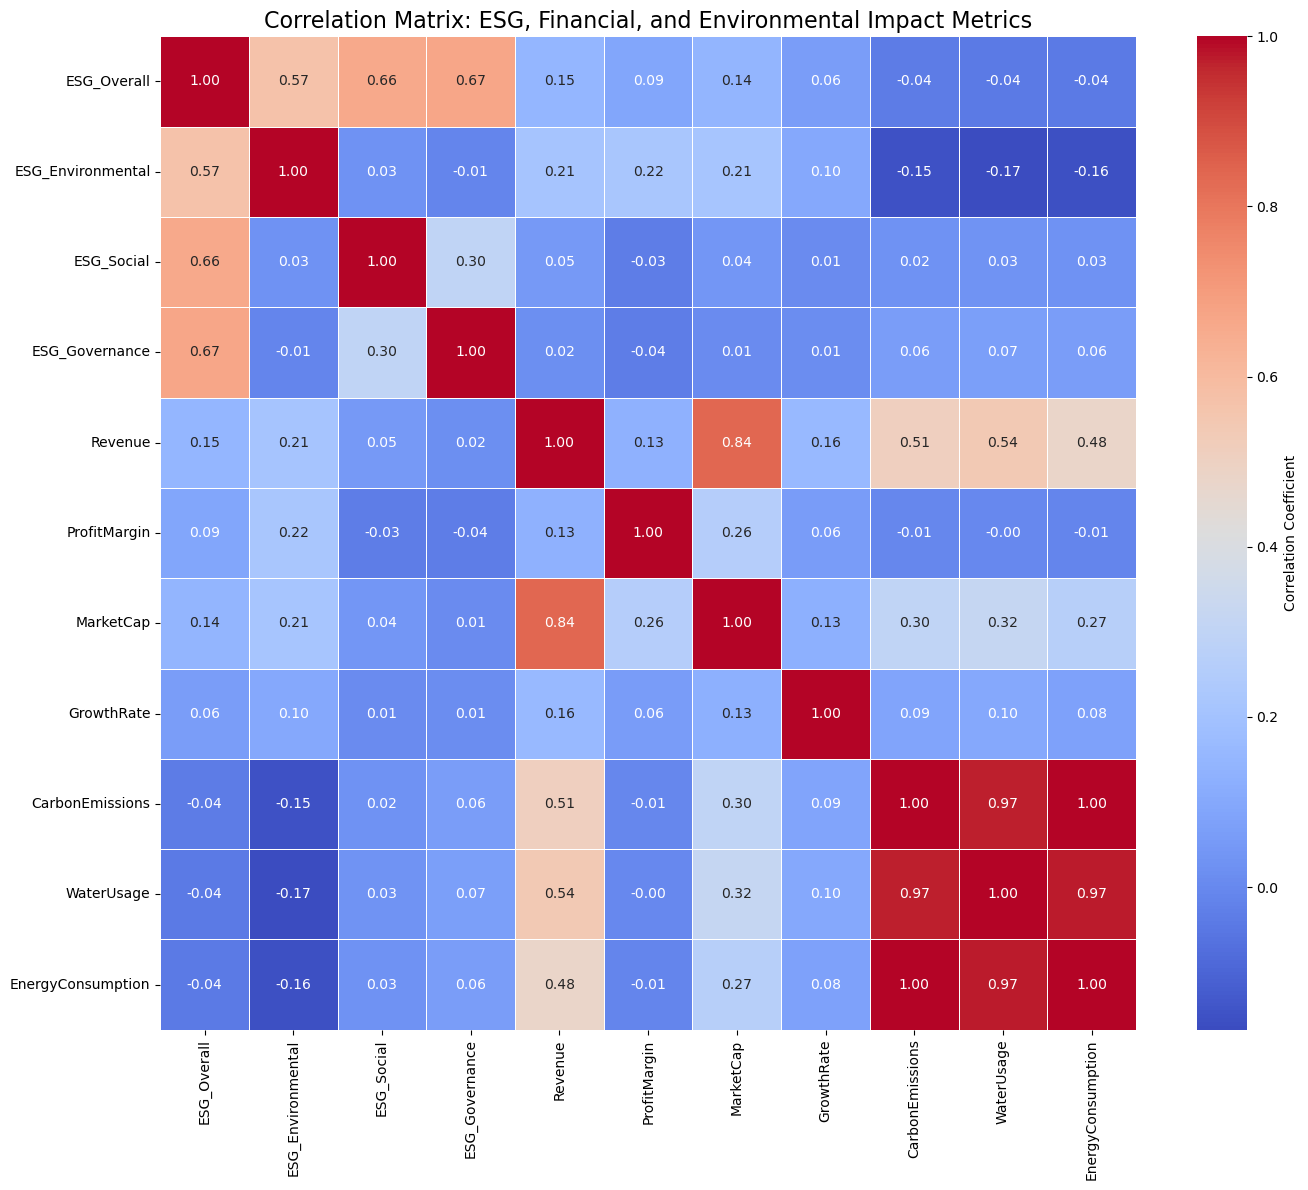


--- Interpretation of Correlation Matrix ---
High positive correlation (closer to +1): As one metric increases, the other tends to increase.
High negative correlation (closer to -1): As one metric increases, the other tends to decrease.
Near zero correlation: Little to no linear relationship.

Key areas to observe:
- Correlations between ESG_Overall and financial metrics (Revenue, ProfitMargin, MarketCap, GrowthRate).
- Correlations between individual ESG pillars (E, S, G) and financial metrics.
- Correlations between environmental impact metrics and financial metrics. For instance, do lower CarbonEmissions correlate with higher ProfitMargin?


In [16]:
# --- 4: Correlation Analysis ---
# Calculating and visualizing the correlations between ESG metrics
# and financial performance metrics to understand their relationship

print("\n--- 4: Correlation Analysis ---")

# Combining relevant columns for correlation analysis
correlation_columns = esg_metrics + financial_metrics + environmental_impact_metrics

# Calculating the correlation matrix
# i must exclude non-numeric columns to ensure only the selected correlation columns are used
df_for_corr = df[correlation_columns].copy()

# Dropping the rows with NaN values in the columns used for correlation calculation

df_for_corr.dropna(inplace=True)

if df_for_corr.empty:
    print("Warning: No valid data for correlation analysis after dropping NaNs. Cannot perform correlation.")
else:
    correlation_matrix = df_for_corr.corr()

    print("\n--- Correlation Matrix (ESG, Financial, Environmental Impact) ---")
    print(correlation_matrix.round(2))

    # Visualizing the correlation matrix using a heatmap
    plt.figure(figsize=(14, 12))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f",
                linewidths=.5, cbar_kws={'label': 'Correlation Coefficient'})
    plt.title('Correlation Matrix: ESG, Financial, and Environmental Impact Metrics', fontsize=16)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    print("\n--- Interpretation of Correlation Matrix ---")
    print("High positive correlation (closer to +1): As one metric increases, the other tends to increase.")
    print("High negative correlation (closer to -1): As one metric increases, the other tends to decrease.")
    print("Near zero correlation: Little to no linear relationship.")
    print("\nKey areas to observe:")
    print("- Correlations between ESG_Overall and financial metrics (Revenue, ProfitMargin, MarketCap, GrowthRate).")
    print("- Correlations between individual ESG pillars (E, S, G) and financial metrics.")
    print("- Correlations between environmental impact metrics and financial metrics. For instance, do lower CarbonEmissions correlate with higher ProfitMargin?")


--- 5: Time-Series Trend Analysis ---

--- Yearly Averages of Key Metrics ---
    Year  ESG_Overall  ESG_Environmental  ESG_Social  ESG_Governance  Revenue  \
0   2015        51.44              51.91       53.13           49.29  3305.84   
1   2016        52.04              52.68       53.57           49.88  3478.71   
2   2017        52.68              53.60       54.01           50.41  3705.97   
3   2018        53.35              54.58       54.58           50.90  3942.49   
4   2019        53.91              55.48       55.03           51.20  4214.27   
5   2020        54.59              56.40       55.70           51.66  4494.45   
6   2021        55.24              57.26       56.25           52.21  4818.39   
7   2022        55.92              58.30       56.72           52.74  5173.36   
8   2023        56.59              59.24       57.29           53.23  5599.79   
9   2024        57.18              60.11       57.76           53.67  6063.94   
10  2025        57.83         

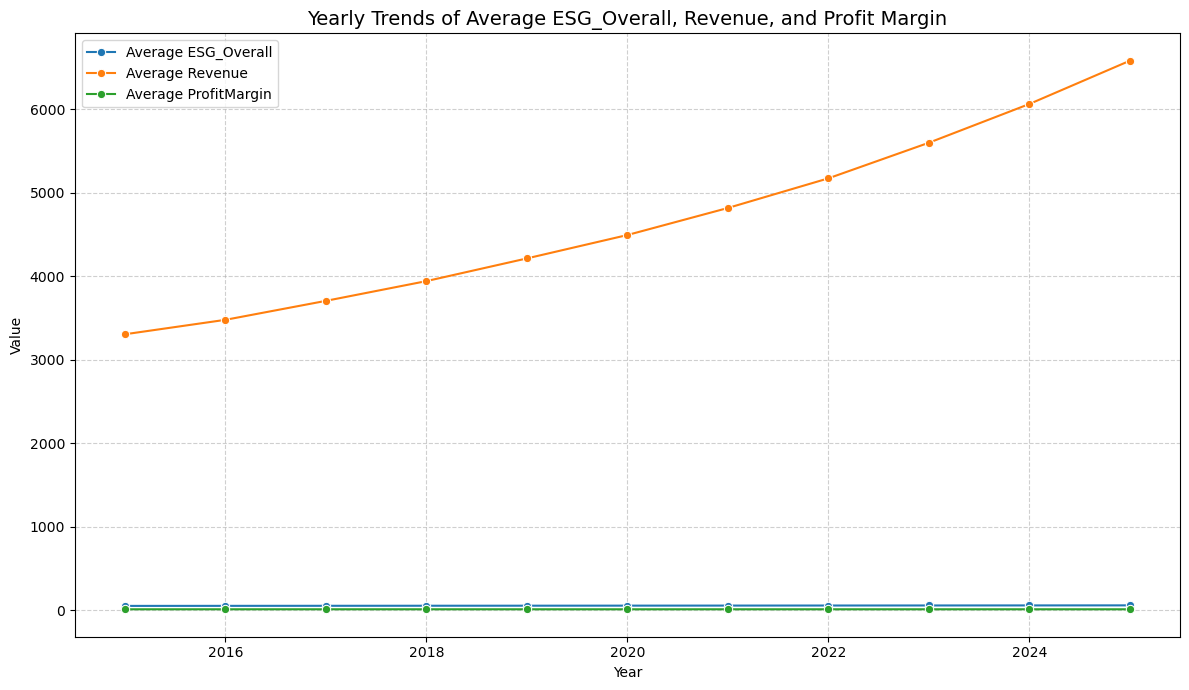


Observation on Yearly Trends:
Look for parallel movements or divergences between ESG scores and financial metrics over time.
For instance, does an increase in ESG_Overall correspond to an increase in ProfitMargin in subsequent years?


In [17]:
# --- 5: Time-Series Trend Analysis (Average per Year) ---
# Examining how average ESG and financial metrics evolve over the years
# covered in the dataset, providing insights into trends and their potential interplay.

print("\n--- 5: Time-Series Trend Analysis ---")

# Grouping by year and calculate the mean for selected numerical columns
# the'Year' field must be a numeric column to enable successful sorting
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
df_yearly_avg = df.groupby('Year')[esg_metrics + financial_metrics + environmental_impact_metrics].mean().reset_index()

if not df_yearly_avg.empty:
    print("\n--- Yearly Averages of Key Metrics ---")
    print(df_yearly_avg.round(2))

    # Plotting annual/yearly trends for ESG_Overall and key financial metrics
    plt.figure(figsize=(12, 7))
    sns.lineplot(data=df_yearly_avg, x='Year', y='ESG_Overall', label='Average ESG_Overall', marker='o')
    sns.lineplot(data=df_yearly_avg, x='Year', y='Revenue', label='Average Revenue', marker='o')
    sns.lineplot(data=df_yearly_avg, x='Year', y='ProfitMargin', label='Average ProfitMargin', marker='o')
    
    # for better visual comparison, i will use a secondary Y-axis or normalize
    # For now, separate plots or careful observation is needed for vastly different scales
    
    plt.title('Yearly Trends of Average ESG_Overall, Revenue, and Profit Margin', fontsize=14)
    plt.xlabel('Year')
    plt.ylabel('Value')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("\nObservation on Yearly Trends:")
    print("Look for parallel movements or divergences between ESG scores and financial metrics over time.")
    print("For instance, does an increase in ESG_Overall correspond to an increase in ProfitMargin in subsequent years?")
else:
    print("Warning: No yearly average data to plot. Check 'Year' column and data integrity.")


--- 6: Predictive Modeling ---

--- Linear Regression Model: Predicting ProfitMargin using ESG_Overall ---
  - Mean Squared Error (MSE): 79.1142
  - R-squared (R2) Score: 0.0031
  - Model Coefficient (change in ProfitMargin per unit change in ESG_Overall): 0.0528
  - Model Intercept: 8.0754


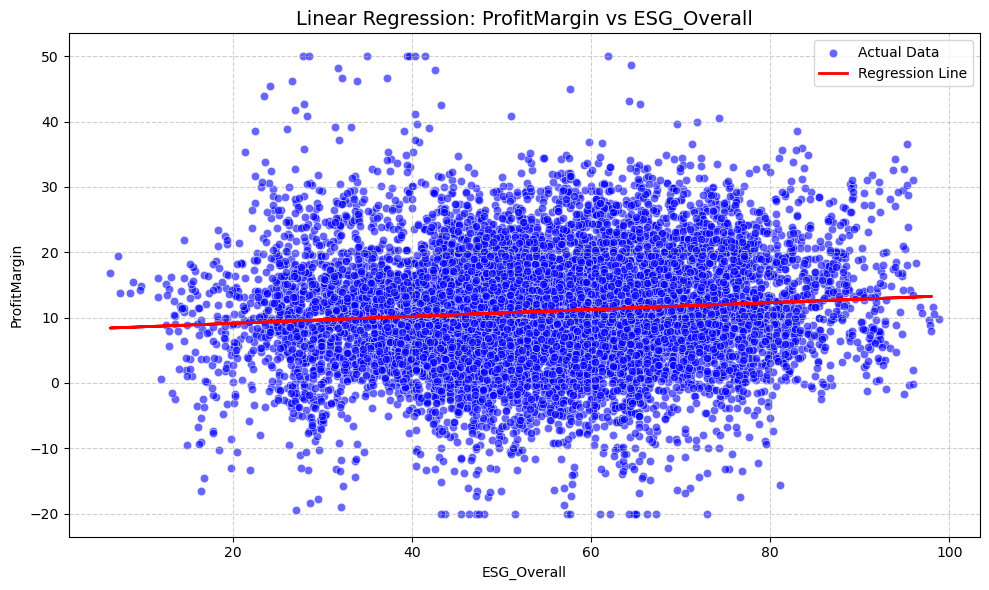


Interpretation:
The R-squared value indicates how much of the variance in ProfitMargin can be explained by ESG_Overall.
A positive coefficient suggests that as ESG_Overall increases, ProfitMargin tends to increase.
A negative coefficient suggests that as ESG_Overall increases, ProfitMargin tends to decrease.


In [18]:
# --- 6: Predictive Modeling (ESG predicting Financial Performance) ---
# Using basic Linear Regression model to get a better understanding of potential investment strategies.

print("\n--- 6: Predictive Modeling ---")

# Defining features (X) and target (y) for a regression model
# Predicting ProfitMargin based on ESG_Overall
feature_col = 'ESG_Overall'
target_col = 'ProfitMargin'

if feature_col in df.columns and target_col in df.columns:
    # Preparing data for modeling
    model_data = df[[feature_col, target_col]].dropna()

    X = model_data[[feature_col]]
    y = model_data[target_col]

    if not model_data.empty and len(model_data) > 1: # i need at least 2 samples for train_test_split
        # Spliting data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        # Initializing and training the Linear Regression model
        model = LinearRegression()
        model.fit(X_train, y_train)

        # Making predictions on the test set
        y_pred = model.predict(X_test)

        # Evaluating the model
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        print(f"\n--- Linear Regression Model: Predicting {target_col} using {feature_col} ---")
        print(f"  - Mean Squared Error (MSE): {mse:.4f}")
        print(f"  - R-squared (R2) Score: {r2:.4f}")
        print(f"  - Model Coefficient (change in {target_col} per unit change in {feature_col}): {model.coef_[0]:.4f}")
        print(f"  - Model Intercept: {model.intercept_:.4f}")

        # Visualizing the regression results
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=X[feature_col], y=y, color='blue', alpha=0.6, label='Actual Data')
        plt.plot(X_test[feature_col], y_pred, color='red', linewidth=2, label='Regression Line')
        plt.title(f'Linear Regression: {target_col} vs {feature_col}', fontsize=14)
        plt.xlabel(feature_col)
        plt.ylabel(target_col)
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

        print("\nInterpretation:")
        print(f"The R-squared value indicates how much of the variance in {target_col} can be explained by {feature_col}.")
        print(f"A positive coefficient suggests that as {feature_col} increases, {target_col} tends to increase.")
        print(f"A negative coefficient suggests that as {feature_col} increases, {target_col} tends to decrease.")
    else:
        print(f"Warning: Insufficient data to build a regression model for {feature_col} and {target_col}.")
else:
    print(f"Warning: One or both of the columns '{feature_col}' or '{target_col}' not found for predictive modeling.")


--- 7: Industry and Region Specific Analysis ---

--- Average ESG and Financials by Industry ---
                ESG_Overall  ESG_Environmental  ESG_Social  ESG_Governance  \
Industry                                                                     
Consumer Goods        54.83              52.08       58.29           54.12   
Energy                49.01              39.66       55.78           51.60   
Finance               64.62              90.25       56.07           47.54   
Healthcare            57.25              66.23       51.64           53.90   
Manufacturing         50.46              41.50       57.28           52.61   
Retail                55.68              57.70       55.81           53.53   
Technology            63.35              84.29       57.46           48.29   
Transportation        46.03              33.85       52.49           51.77   
Utilities             51.60              46.18       56.75           51.87   

                 Revenue  ProfitMargin  Mar

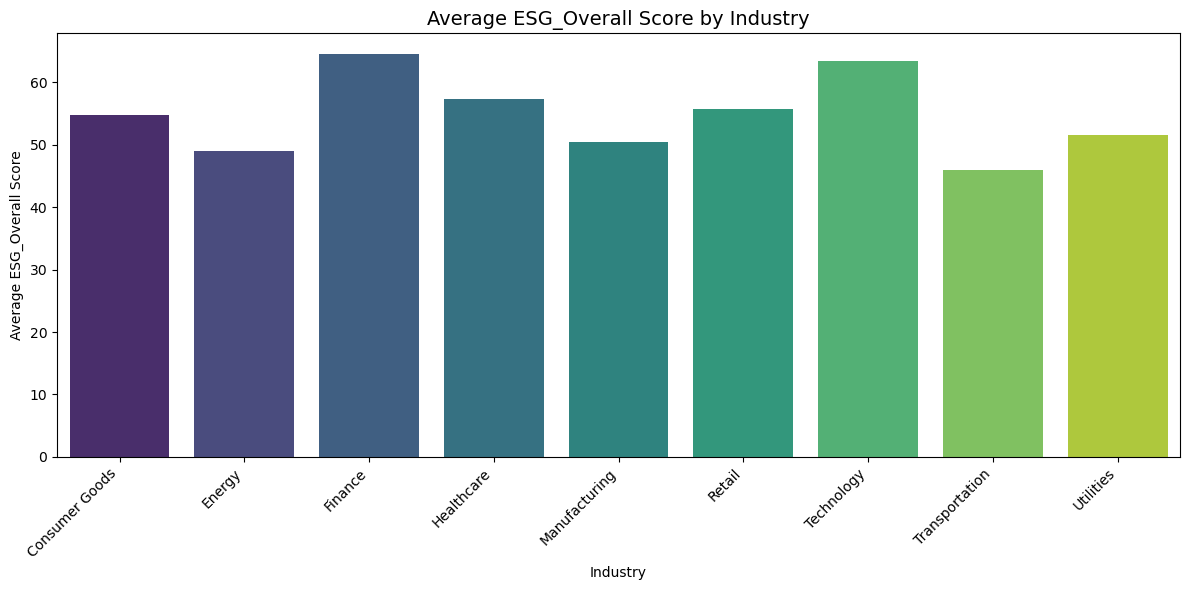


--- Average ESG and Financials by Region ---
               ESG_Overall  ESG_Environmental  ESG_Social  ESG_Governance  \
Region                                                                      
Africa               44.51              57.09       43.23           33.20   
Asia                 51.90              54.47       49.58           51.65   
Europe               67.87              58.26       73.22           72.11   
Latin America        50.52              58.27       51.55           41.74   
Middle East          43.44              57.62       39.73           32.98   
North America        61.22              52.97       61.74           68.94   
Oceania              62.44              56.41       70.05           60.84   

               Revenue  ProfitMargin  MarketCap  GrowthRate  
Region                                                       
Africa         4061.01         11.37   11749.99        4.55  
Asia           4182.60         11.34   12591.26        4.84  
Europe      

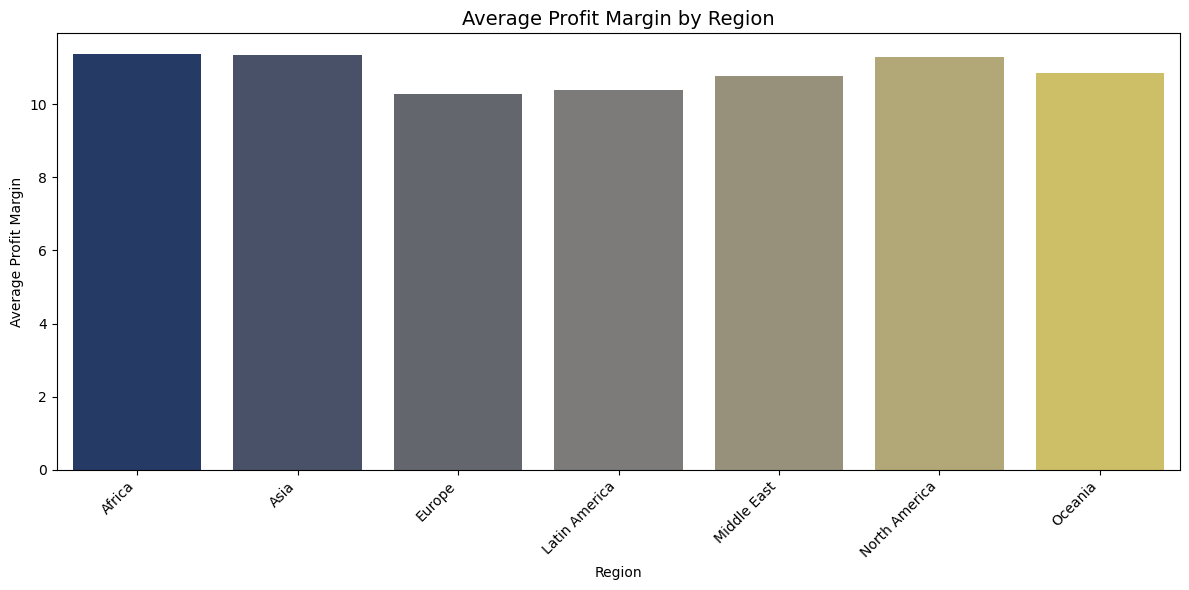

In [19]:
# --- 7: Industry and Region Specific Analysis ---
# Exploring how ESG and financial relationships might vary across
# different industries and geographical regions, which is crucial for
# targeted sustainable investment strategies.

print("\n--- 7: Industry and Region Specific Analysis ---")

# determining the Average ESG and Financials by Industry
if 'Industry' in df.columns:
    print("\n--- Average ESG and Financials by Industry ---")
    df_industry_avg = df.groupby('Industry')[esg_metrics + financial_metrics].mean()
    print(df_industry_avg.round(2))

    # Visualizing the average ESG_Overall by Industry
    plt.figure(figsize=(12, 6))
    sns.barplot(x=df_industry_avg.index, y='ESG_Overall', data=df_industry_avg, palette='viridis')
    plt.title('Average ESG_Overall Score by Industry', fontsize=14)
    plt.xlabel('Industry')
    plt.ylabel('Average ESG_Overall Score')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("Warning: 'Industry' column not found for industry-specific analysis.")

# Determining the average ESG and Financials by Region
if 'Region' in df.columns:
    print("\n--- Average ESG and Financials by Region ---")
    df_region_avg = df.groupby('Region')[esg_metrics + financial_metrics].mean()
    print(df_region_avg.round(2))

    # Visualizing the average ProfitMargin by Region
    plt.figure(figsize=(12, 6))
    sns.barplot(x=df_region_avg.index, y='ProfitMargin', data=df_region_avg, palette='cividis')
    plt.title('Average Profit Margin by Region', fontsize=14)
    plt.xlabel('Region')
    plt.ylabel('Average Profit Margin')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("Warning: 'Region' column not found for region-specific analysis.")